In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kstest, norm
import scipy.stats as stats
from scipy.stats import spearmanr
from sklearn.preprocessing import PowerTransformer

# 차원 축소
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 군집
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# 학습 모델 저장을 위한 라이브러리
import pickle

### 가설1 : Segment 등급이 높을수록 최근 3개월간 카드 이용금액이 높을 것이다

In [2]:
# 데이터를 불러온다.
df = pd.read_parquet("data/r05.parquet")
# df

In [3]:
# 필요한 컬럼 추출
df_g1 = df[['Segment', '이용금액_R3M_신용체크']].dropna()

In [4]:
# 이용금액_일시불_R3M 평균, 중앙값, 표준편차
df_g1.groupby('Segment')['이용금액_R3M_신용체크'].agg(['mean', 'median', 'std'])

,mean,median,std
Segment,,,
A,98294.205761,108945.0,36545.796723
B,91296.145833,101807.0,34092.876196
C,60613.194490,59970.0,37380.514019
D,38603.933347,33633.0,27130.470962
E,10054.584928,5707.0,13583.772374


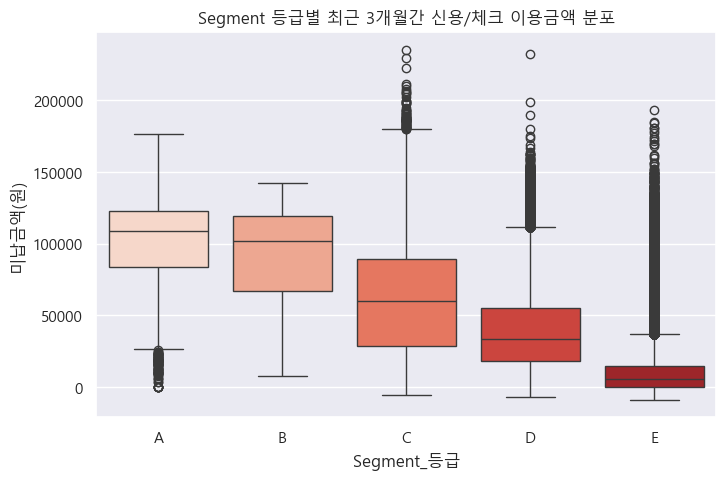

In [23]:
# Boxplot 시각화
plt.figure(figsize=(8, 5))
sns.boxplot(x='Segment', y='이용금액_R3M_신용체크', data=df_g1, order=['A', 'B', 'C', 'D', 'E'], palette='Reds')
plt.title('Segment 등급별 최근 3개월간 신용/체크 이용금액 분포')
plt.ylabel('미납금액(원)')
plt.xlabel('Segment_등급')
plt.show()

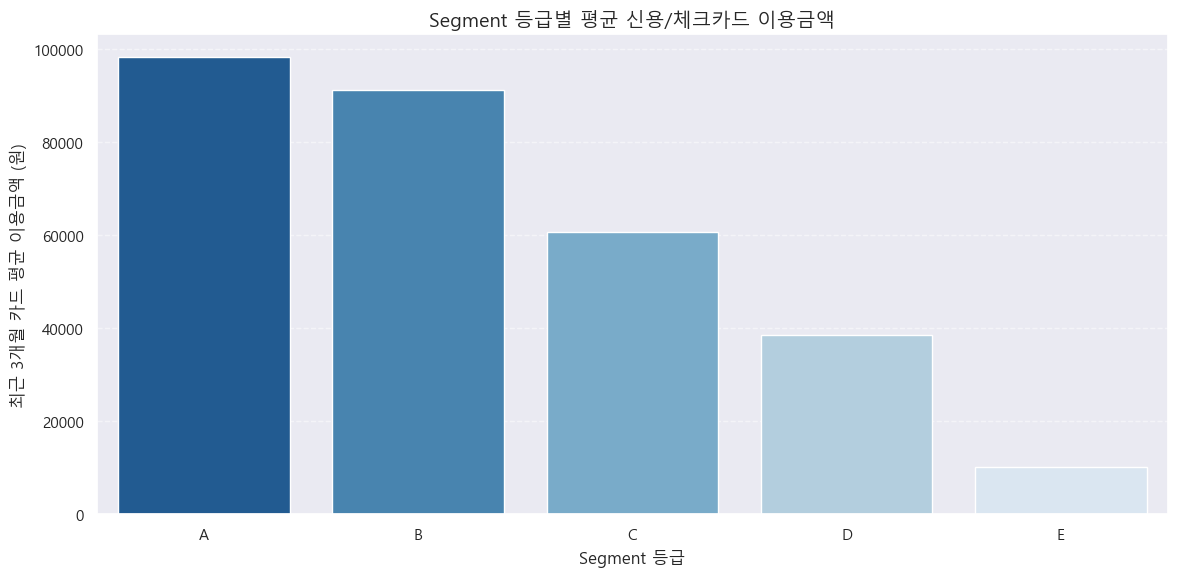

In [5]:
# Segment별 평균 이용금액 bar plot
# 평균 금액
# A: 98294, B: 91296, C: 60613, D: 38603, E: 10054 
df_bar = df_g1.groupby('Segment')['이용금액_R3M_신용체크'].mean().reset_index()
sns.barplot(x='Segment', y='이용금액_R3M_신용체크', data=df_bar, palette='Blues_r')


plt.title('Segment 등급별 평균 신용/체크카드 이용금액', fontsize=14)
plt.xlabel('Segment 등급')
plt.ylabel('최근 3개월 카드 평균 이용금액 (원)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

- Segment 등급이 높을수록 (A > B > C > D > E) 카드 평균 이용금액이 뚜렷하게 높아진다.

### 가설2 : 정상입금원금이 높을수록 상위 등급(A, B) 비중이 크다
 1) 컬럼 : 정상입금원금_B0M, Segment
 2) 분석 방법
  - 정상입금원금 평균 계산 후, Segment 별 비율 분석 v
  - 다항 로지스틱 회귀 분석
        (입금원금 → Segment 예측) 
 3) 인사이트
  - 입금 이력이 좋은 고객이 실제로 신용 우량자로 분류되는지 확인 가능.
  - 신용 평가 모델의 타당성 점검 가능

In [6]:
# 필요한 컬럼 추출
df_g2 = df[['Segment', '정상입금원금_B0M']].dropna()
df_g2

,Segment,정상입금원금_B0M
0,D,6335
1,E,5198
2,C,12564
3,D,7639
4,E,0
...,...,...
2399995,E,0
2399996,D,9705
2399997,C,5346
2399998,E,0


### 정상입금원금 평균 계산 후, Segment 별 비율 분석

In [7]:
# Segment별 정상입금원금_B0M 평균 구하기
segment_mean = df_g2.groupby('Segment')['정상입금원금_B0M'].mean().reset_index().sort_values(by='정상입금원금_B0M', ascending=False)
print(segment_mean)

  Segment    정상입금원금_B0M
0       A  33309.734568
1       B  23212.340278
2       C  12567.086888
3       D   7071.397773
4       E   2219.050961


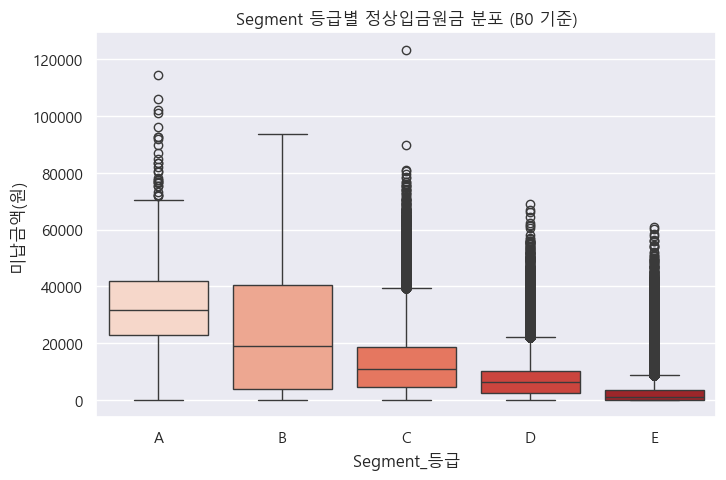

In [8]:
# Boxplot 시각화
plt.figure(figsize=(8, 5))
sns.boxplot(x='Segment', y='정상입금원금_B0M', data=df_g2, order=['A', 'B', 'C', 'D', 'E'], palette='Reds')
plt.title('Segment 등급별 정상입금원금 분포 (B0 기준)')
plt.ylabel('미납금액(원)')
plt.xlabel('Segment_등급')
plt.show()

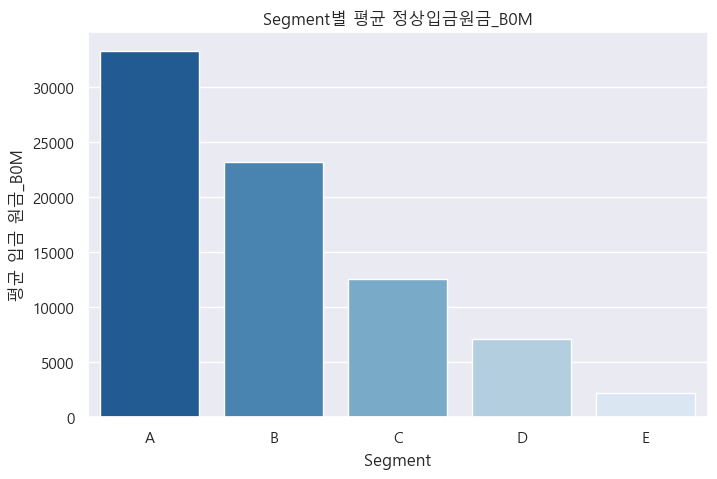

In [9]:
# Segment별 정상입금원금_B0M 평균 비교(시각화)
plt.figure(figsize=(8, 5))
sns.barplot(x='Segment', y='정상입금원금_B0M', data=segment_mean, estimator='mean', order=sorted(df['Segment'].unique()), palette='Blues_r')
plt.title('Segment별 평균 정상입금원금_B0M')
plt.ylabel('평균 입금 원금_B0M')
plt.show()

In [10]:
# Segment별 상위 입금액 고객 비율 비교(상위 25% 기준)
# 상위 25%라는 기준?
# 근거가 필요할 것으로 보임
# 일단 임의로 25%로 정하고 분석 진행
# 전체에서 입금원금 기준 상위 25% 커트라인 계산
threshold = df_g2['정상입금원금_B0M'].quantile(0.75)

# 상위 고객 여부 파생변수 생성
df_g2['상위입금고객'] = df_g2['정상입금원금_B0M'] >= threshold

# Segment별 상위입금고객 비율
segment_ratio = df_g2.groupby('Segment')['상위입금고객'].mean().reset_index()
segment_ratio.rename(columns={'상위입금고객': '상위입금고객_비율'}, inplace=True)

print(segment_ratio)

  Segment  상위입금고객_비율
0       A   0.976337
1       B   0.750000
2       C   0.741328
3       D   0.598279
4       E   0.153718


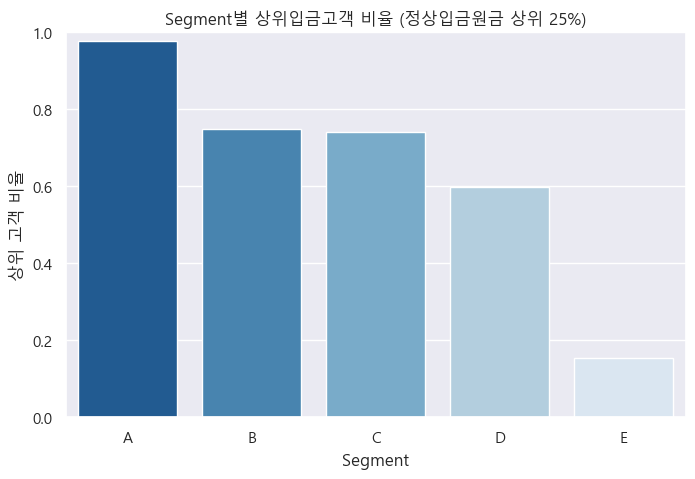

In [11]:
# 상위입금고객 비율(시각화)
plt.figure(figsize=(8, 5))
sns.barplot(x='Segment', y='상위입금고객_비율', data=segment_ratio, order=sorted(df['Segment'].unique()), palette='Blues_r')
plt.title('Segment별 상위입금고객 비율 (정상입금원금 상위 25%)')
plt.ylabel('상위 고객 비율')
plt.ylim(0, 1)
plt.show()

### 가설3 : 최근 3개월간 일시불 금액이 클수록 Segment 등급 A,B에 많이 분포된다. 
1. 컬럼 : 이용금액_일시불_R3M, Segment
2. 분석 방법
- 비교 시각화 (Boxplot, Violin plot)
3. 인사이트
- 해당 금액이 등급 산정 요소인지 확인 가능

In [12]:
# 필요한 컬럼 추출
df_g3 = df[['Segment', '이용금액_일시불_R3M']].dropna()
df_g3

,Segment,이용금액_일시불_R3M
0,D,2877
1,E,14316
2,C,15694
3,D,-2710
4,E,-3383
...,...,...
2399995,E,0
2399996,D,24946
2399997,C,13424
2399998,E,0


### Box plot 시각화

In [13]:
# 이용금액_일시불_R3M 평균, 중앙값, 표준편차
df_g3.groupby('Segment')['이용금액_일시불_R3M'].agg(['mean', 'median', 'std'])

,mean,median,std
Segment,,,
A,57948.247942,64860.5,20965.779026
B,52665.722222,62816.0,23298.624243
C,34922.695838,35143.0,22082.007855
D,22395.242740,20165.0,16280.498240
E,6961.624167,3861.0,9216.351478


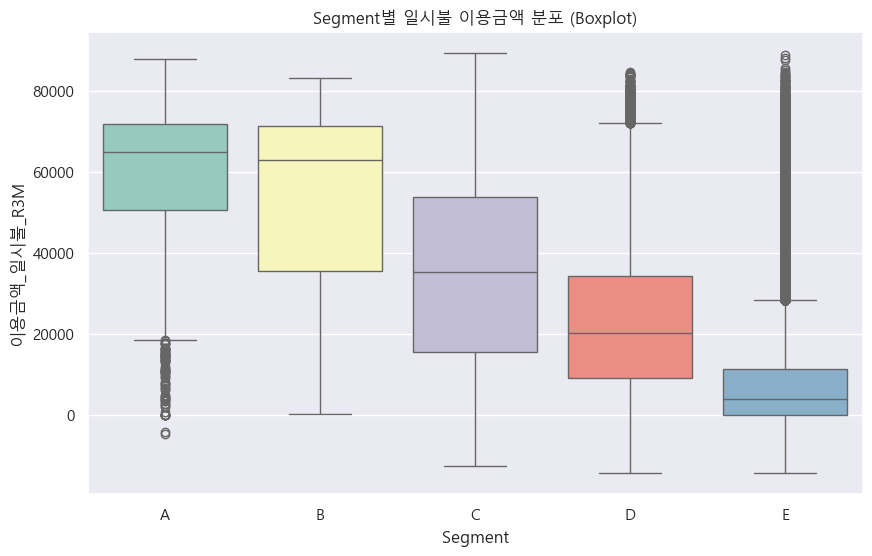

In [14]:
# Box plot 시각화
# 중앙값(A: 64860.5, B: 62816, C: 35143, D: 20165, E: 3861)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Segment', y='이용금액_일시불_R3M', data=df_g3, order=['A', 'B', 'C', 'D', 'E'], palette='Set3')
plt.title('Segment별 일시불 이용금액 분포 (Boxplot)')
plt.show()

In [15]:
# 위 그래프를 보았을 때 극단치가 너무 많으므로 중앙값으로 비교를 한다.
# 평균을 사용하면 왜곡 결과가 나올 가능성이 높다.
# 중앙값은 극단치에 영향을 받지 않음.

- Segment 등급이 E로 갈수록 중앙값이 급격히 낮아지는 패턴이 보인다.
- 상위 등급(A, B)에 속할수록 실질적인 소비력(일반적인 고객의 소비 수준)이 높다는 사실을 알 수 있다.
- 등급 D, E는 중앙값이 현저히 낮은 걸로 보아 실질적으로 대부분의 고객이 낮은 금액대에 집중되어 있다.

### Violinplot 시각화

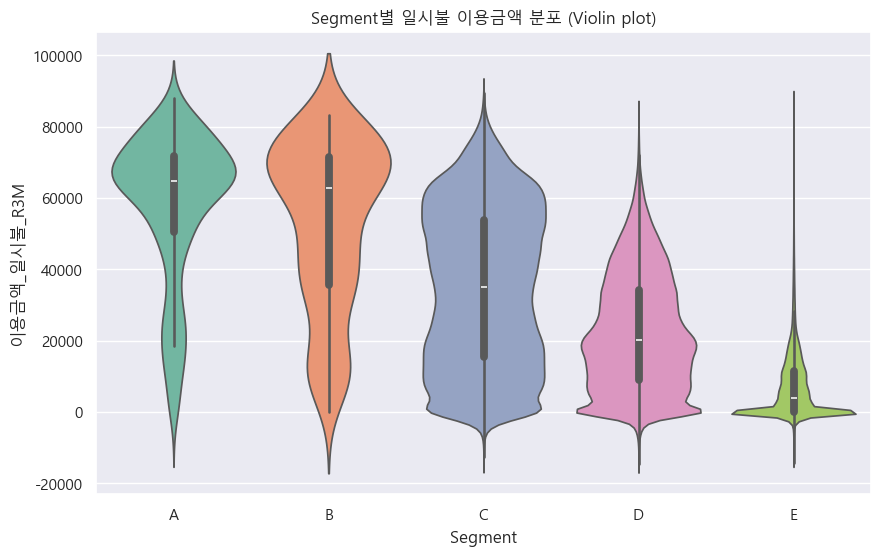

In [16]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Segment', y='이용금액_일시불_R3M', data=df_g3, order=['A', 'B', 'C', 'D', 'E'], palette='Set2')
plt.title('Segment별 일시불 이용금액 분포 (Violin plot)')
plt.show()

- A, B: 고소비 구간에 고객이 많이 몰려 있음
- C: 쌍봉형 분포를 가짐. 고객군이 고소비군과 중소비군으로 이분화됨
- D, E: 중앙값도 낮고 분포가 저금액에 몰려 있음. 특히 E는 0근처에 대부분 밀집되어 있음을 알 수 있음.
   => 즉, 집단 E는 소비력이 매우 낮은 집단이라고 할 수 있다.

- Segment A, B는 중앙값도 높고, 고금액 구간에 고객들이 밀집되어 있음.
- 반면 Segment D, E는 중앙값도 낮고 분포도 저금액에 몰려 있음.

### 가설4 : 미납금액이 클수록 고객은 D 또는 E 등급일 확률이 높다
 1) 컬럼 : 청구금액_B0, 정상입금원금_B0M, Segment
 2) 분석 방법
 - 미납금액 파생변수 생성 (청구금액 - 정상입금원금)
 - 등급별 미납금액 Boxplot 

In [17]:
# 필요한 컬럼 추출
df_g4 = df[['Segment', '청구금액_B0', '정상입금원금_B0M']].dropna()
df_g4

,Segment,청구금액_B0,정상입금원금_B0M
0,D,12226,6335
1,E,5834,5198
2,C,21866,12564
3,D,16356,7639
4,E,0,0
...,...,...,...
2399995,E,0,0
2399996,D,14402,9705
2399997,C,5731,5346
2399998,E,0,0


In [18]:
# 파생변수 생성 : 미납금액_B0
df_g4['미납금액_B0'] = df_g4['청구금액_B0'] - df_g4['정상입금원금_B0M']

In [19]:
# 미납금액_B0 평균, 중앙값, 표준편차
df_g4.groupby('Segment')['미납금액_B0'].agg(['mean', 'median', 'std'])

,mean,median,std
Segment,,,
A,16204.629630,12174.5,17557.467150
B,24388.326389,21228.5,20057.777012
C,7434.458210,3798.5,10585.132583
D,3632.470954,1532.0,6056.715386
E,803.240414,2.0,2388.255888


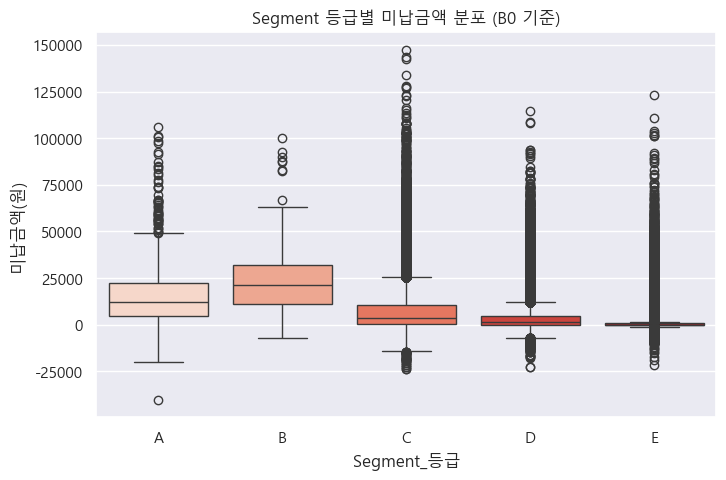

In [20]:
# Boxplot 시각화
plt.figure(figsize=(8, 5))
sns.boxplot(x='Segment', y='미납금액_B0', data=df_g4, order=['A', 'B', 'C', 'D', 'E'], palette='Reds')
plt.title('Segment 등급별 미납금액 분포 (B0 기준)')
plt.ylabel('미납금액(원)')
plt.xlabel('Segment_등급')
plt.show()

In [21]:
# 극단치가 다수 존재하므로 평균보다는 중앙값 위주로 분석하고자 한다.
# 중앙값
# A : 12174.5, B : 21228.5, C : 3798.5, D : 1532, E : 2

- A, B 등급의 미납금액 중앙값이 C,D,E보다 오히려 높다.
- 즉, 등급이 낮다고 반드시 전체적으로 미납금이 많다고 보기는 어렵다는 사실을 알 수 있다.
- C, D, E 등급에는 고액 미납 이상치 고객이 많다.
- 이에 일부 위험 고객은 포함되어 있으면, 등급 내에서도 이질적인 분포가 있을 수 있음.
- 따라서, 미납금액의 크기가 등급을 직접적으로 결정하지 않으며, Segment 등급 분류 기준은 미납금 외 다양한 요소가 반영되어 있을 가능성이 있다.